# **Prétraitement**

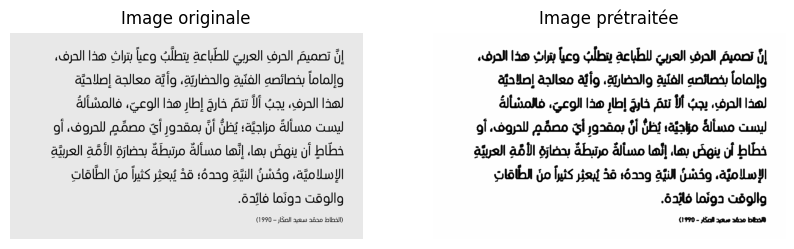

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("samples/sample2.png", cv2.IMREAD_GRAYSCALE)

#filtrage médian pour réduire le bruit
image_filtre = cv2.medianBlur(image, 5)

# Normaliser l'image pour améliorer le contraste
image_norm = cv2.equalizeHist(image_filtre)

#affichage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image prétraitée")
plt.imshow(image_norm, cmap="gray")
plt.axis("off")
plt.show()

# **Implémentation de la croissance de régions**

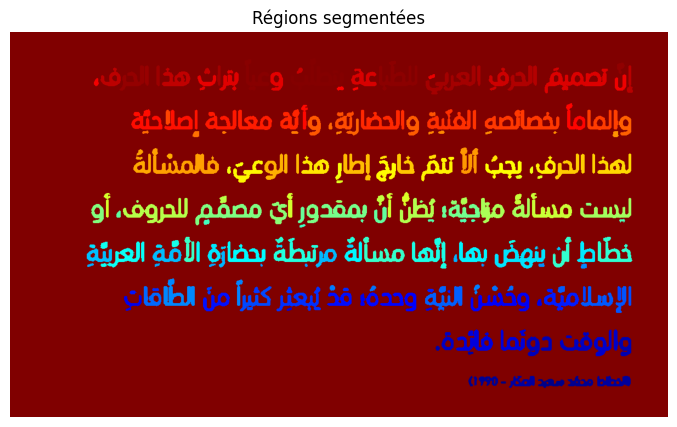

In [67]:
def croissance_regions(image, seuil=20, seuil_seed=20):

    h, w = image.shape
    visited = np.zeros((h, w), dtype=bool)
    regions = np.zeros((h, w), dtype=np.int32)
    region_id = 1

    for i in range(h):
        for j in range(w):
            # Condition pour qu'un pixel soit un seed
            if not visited[i, j] and image[i, j] <= seuil_seed:
                region_pixels = [(i, j)]
                intensite_seed = image[i, j]

                while region_pixels:
                    x, y = region_pixels.pop()

                    if not visited[x, y]:
                        visited[x, y] = True
                        regions[x, y] = region_id

                        # Vérifier les voisins
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nx, ny = x + dx, y + dy

                            if 0 <= nx < h and 0 <= ny < w:
                                if not visited[nx, ny]:
                                    # Vérifier la condition d'homogénéité
                                    if abs(int(image[nx, ny]) - int(intensite_seed)) <= seuil:
                                        region_pixels.append((nx, ny))

                region_id += 1

    return regions


#appliquer la croissance de régions
regions = croissance_regions(image_norm)

# générer une image colorée pour visualisation
region_colored = cv2.applyColorMap((regions * 255 // regions.max()).astype(np.uint8), cv2.COLORMAP_JET)

# afficher les régions
plt.figure(figsize=(10, 5))
plt.title("Régions segmentées")
plt.imshow(region_colored)
plt.axis("off")
plt.show()

# **Post-traitement**

In [68]:
# Supprimer les régions trop petites et extraire des sous-images
def post_traitement(regions, min_size=50):
    unique_regions, counts = np.unique(regions, return_counts=True)
    filtered_regions = np.zeros_like(regions)

    for region, count in zip(unique_regions, counts):
        if count >= min_size:
            filtered_regions[regions == region] = region

    return filtered_regions

# Supprimer les régions trop petites
filtered_regions = post_traitement(regions)

# **Calcul des distances entre regions**

In [ ]:
def calcul_boites_englobantes(regions):

    # Récupère les identifiants uniques des régions (sauf le fond 0)
    region_ids = np.unique(regions)
    region_ids = region_ids[region_ids != 0]
    
    boites_englobantes = {}

    for rid in region_ids:
        # Récupérer les coordonnées des pixels 
        coords = np.argwhere(regions == rid)   
     
        if coords.size == 0:
            continue

        # Calculer la ligne minimale et maximale
        min_row = coords[:, 0].min()
        max_row = coords[:, 0].max()
        # Calculer la colonne minimale et maximale
        min_col = coords[:, 1].min()
        max_col = coords[:, 1].max()

        boites_englobantes[rid] = (min_col, min_row, max_col, max_row)
        
    return boites_englobantes

In [69]:
def calcul_distances(boite1, boite2):

    # Extraction des coordonnées des boîtes
    min_x1, min_y1, max_x1, max_y1 = boite1
    min_x2, min_y2, max_x2, max_y2 = boite2

    # Calcul de la distance horizontale entre les boîtes
    if max_x1 < min_x2:  
        dx = min_x2 - max_x1
    elif max_x2 < min_x1: 
        dx = min_x1 - max_x2
    else: 
        dx = 0

    # Calcul de la distance verticale entre les boîtes
    if max_y1 < min_y2:  
        dy = min_y2 - max_y1
    elif max_y2 < min_y1: 
        dy = min_y1 - max_y2
    else:  
        dy = 0

    # Retourner la distance euclidienne entre les boîtes
    return np.sqrt(dx**2 + dy**2)


# Calcul des boîtes englobantes pour chaque région identifiée dans l'image
boites = calcul_boites_englobantes(filtered_regions)

distances = {}  
region_ids = list(boites.keys())  

# Parcours de toutes les paires de régions pour calculer leur distance
for i in range(len(region_ids)):
    for j in range(i + 1, len(region_ids)):  
        rid1 = region_ids[i]
        rid2 = region_ids[j]
        dist = calcul_distances(boites[rid1], boites[rid2])  
        distances[(rid1, rid2)] = dist  


# **Fusionnement des regions**

In [70]:
def merge_regions(regions, distances, fusion_seuil):

    region_ids = np.unique(regions)
    region_ids = region_ids[region_ids != 0]

    # Initialisation d'un dictionnaire où chaque région est son propre groupe
    groups = {rid: {rid} for rid in region_ids}

    merged = True
    while merged:
        merged = False  

        # Parcours de toutes les paires de régions pour vérifier si elles doivent être fusionnées
        for (rid1, rid2), dist in distances.items():
            if dist < fusion_seuil:  
                group1 = None
                group2 = None

                for g in groups.values():
                    if rid1 in g:
                        group1 = g
                    if rid2 in g:
                        group2 = g

                # Fusionner les groupes s'ils sont différents
                if group1 is not None and group2 is not None and group1 is not group2:
                    group1.update(group2)  

                    # Supprimer l'ancien groupe fusionné
                    keys_to_remove = [key for key, val in groups.items() if val == group2]
                    for key in keys_to_remove:
                        del groups[key]

                    merged = True  
                    break  

    # Création d'un dictionnaire de correspondance entre les anciens identifiants et les nouveaux fusionnés
    mapping = {}
    for group in groups.values():
        rep = min(group)  
        for rid in group:
            mapping[rid] = rep  

    # Mise à jour de la matrice des régions avec les nouveaux identifiants fusionnés
    new_regions = np.copy(regions)
    for rid in region_ids:
        new_regions[regions == rid] = mapping[rid]

    # Relabellisation des régions fusionnées pour avoir des identifiants consécutifs
    unique_labels = np.unique(new_regions)
    label_mapping = {}
    new_label = 1
    for label in unique_labels:
        if label == 0:  
            continue
        label_mapping[label] = new_label
        new_label += 1

    # Appliquer la nouvelle numérotation aux régions
    for old_label, new_label in label_mapping.items():
        new_regions[new_regions == old_label] = new_label

    return new_regions, mapping


# Définition du seuil de fusion et exécution de la fusion des régions
fusion_seuil = 10  
new_regions, region_mapping = merge_regions(regions, distances, fusion_seuil)


# **Resultats**

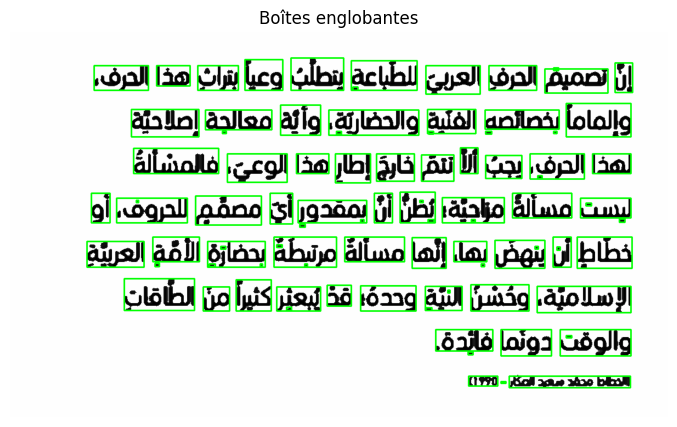

In [71]:
# Creation des nouvelles boites englobantes
boites_englobantes = calcul_boites_englobantes(new_regions)

# Affichage des boîtes englobantes
output_image = cv2.cvtColor(image_norm, cv2.COLOR_GRAY2BGR)
for rid,(x_min, y_min, x_max, y_max) in boites_englobantes.items():
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.title("Boîtes englobantes")
plt.imshow(output_image)
plt.axis("off")
plt.show()